In [1]:
'''IMPORT LIBRARIES'''
import requests
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
# import cv2

from scipy.misc import imresize
from sklearn.model_selection import train_test_split

from keras.applications.resnet50 import ResNet50
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.layers import Input, Reshape, UpSampling2D, InputLayer, Lambda, ZeroPadding2D
from keras.layers import Cropping2D, Conv2DTranspose, BatchNormalization, Activation, GlobalAveragePooling2D
from keras.utils import np_utils, to_categorical
from keras.losses import binary_crossentropy
from keras import backend as K,objectives
from keras.losses import mse, binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
from keras.preprocessing import image
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import random

from sklearn.utils.class_weight import compute_class_weight
from PIL import Image

from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

# os.chdir("/content/gdrive/Team Drives/AC209b_final_project/")

np.random.seed(42)

Using TensorFlow backend.


## Data Preparation

The training data are stored in tfrecords files. We extract the images and store them in corresponding folder with the implemented class $\texttt{TFRecordExtractor}$. The labels and images location are stored in a $\texttt{.csv}$ file. To extract the tfrecords, we used the implementation found in [1]. Once we have post-processed the images into their respective folder, we build one global folder $\texttt{images}$ containing all the images and one $\texttt{.csv}$ file $\texttt{training_data.csv}$ containing the labels and the file locations.

Let us load the test and training data as dataframes with columns corresponding to the image ID, the class, the filename, and the response variable (class).

In [225]:
'''LOAD TEST AND CROSS-VALIDATION DATA'''

# load npy files
cv10_labels   = np.load('data/cv10_labels.npy')
cv10_data     = np.load('data/cv10_data.npy')
test10_data   = np.load('data/test10_data.npy')
test10_labels = np.load('data/test10_labels.npy')

# combine test and validation sets
test_data   = np.vstack((cv10_data,test10_data))
test_labels = np.concatenate((cv10_labels,test10_labels))
assert(test_data.shape[0] == len(test_labels))

# shuffle combined test/validation set
test_indexes = np.array(list(range(len(test_labels))))
np.random.shuffle(test_indexes)
test_data   = test_data[test_indexes]
test_labels = test_labels[test_indexes]

In [226]:
'''SAVE TEST DATA AS DF'''
test_df_ref = pd.DataFrame()
test_df_ref['id'] = ['img'+str(i+1) for i in range(test_labels.shape[0])]
test_df_ref['class'] = test_labels
test_df_ref['filename'] = [i+'.png' for i in test_df_ref['id'].values]
test_df_ref['y'] = test_labels
test_df_ref.loc[:,'y'] = test_df_ref.loc[:,'y'].astype('str')
test_df_ref =test_df_ref.reset_index()
test_df_ref.head()

,index,id,class,filename,y
0,0,img1,0,img1.png,0
1,1,img2,0,img2.png,0
2,2,img3,0,img3.png,0
3,3,img4,0,img4.png,0
4,4,img5,1,img5.png,1


## Load training data

In [4]:
'''LOAD TRAINING DATA'''

#Import csv
train_label_baseline_df = pd.read_csv('data/training_data.csv')
train_label_baseline_df = train_label_baseline_df.drop(columns=['normal_class','Unnamed: 0'])

#Create new columns filename and y
train_label_baseline_df['filename'] = train_label_baseline_df['id'].apply(lambda x: x+'.png')
train_label_baseline_df['y'] = train_label_baseline_df['class'].astype('str')
train_label_baseline_df =train_label_baseline_df.reset_index()
train_label_baseline_df.head()

,index,id,class,filename,y
0,0,c1,0,c1.png,0
1,1,c2,0,c2.png,0
2,2,c3,0,c3.png,0
3,3,c4,4,c4.png,4
4,4,c5,0,c5.png,0


## Preliminary Analysis

### Summary Tables

First, we can investigate the number of images we have in each class in the train and test sets.

In [5]:
summary_counts_df = pd.DataFrame({'train': train_label_baseline_df['class'].value_counts(),
                                  'test': pd.Series(test_labels).value_counts()}).fillna(0)
summary_counts_df = summary_counts_df.astype(int)
summary_counts_df.index.name = 'class'
display(summary_counts_df)

totals = pd.DataFrame(summary_counts_df.sum())
totals.columns = ["totals"]
display(totals)

,train,test
class,,
0,48596,13360
1,2103,558
2,1911,642
3,1463,369
4,1812,435


,totals
train,55885
test,15364


The class distribution in the train set can be highlighted through bar charts.

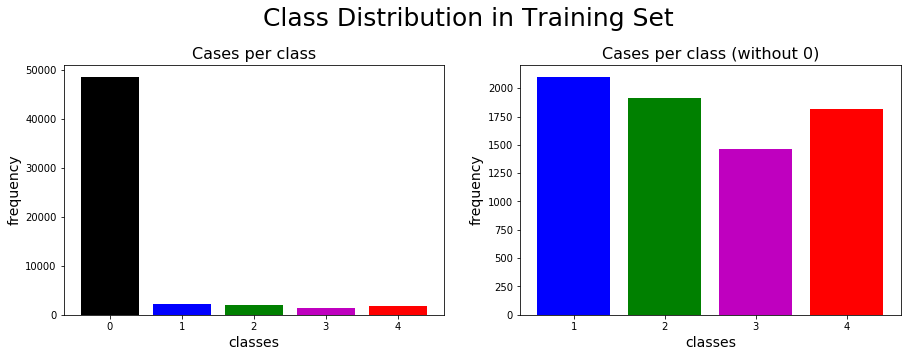

In [7]:
class_freq = summary_counts_df['train'].values
fig = plt.figure(figsize=(15,5))
ax0 = fig.add_subplot(121)
ax0.bar(range(0,5),class_freq,color=['k','b','g','m','r'])
ax0.set_xlabel('classes', fontsize=14)
ax0.set_ylabel('frequency', fontsize=14)
ax0.set_title('Cases per class', fontsize=16)
ax1 = fig.add_subplot(122)
ax1.bar(range(1,5),class_freq[1::],color=['b','g','m','r'])
ax1.set_xlabel('classes', fontsize=14)
ax1.set_ylabel('frequency', fontsize=14)
ax1.set_title('Cases per class (without 0)', fontsize=16)
ax1.set_xticks(range(1,5));
plt.suptitle('Class Distribution in Training Set',fontsize=25)
plt.subplots_adjust(top=0.82)

The normal type (class 0) is dominant in the dataset with the four other labels almost uniformly distributed. We will therefore need to address the imbalance between the negative (normal) and positive (i.e. suspicious-growth) classes when fitting classifiers to the training set.

### Randomly-selected instances of each class
Let us plot a random image from each class

In [9]:
'''FUNCTION TO PLOT IMAGE FROM ID'''
def load_image(image_id,show=False):
    '''
    -----------------------------------------------------------------------
    Function to load image from file location and normalize between 0 and 1
    -----------------------------------------------------------------------
    Param[in] image_id .. double of image id
    Param[out] path .. string of image location
    '''
    image = Image.open('./images/'+image_id+'.png')
    image = list(image.getdata())
    image = np.array(image)
    image = np.reshape(image,(299,299,1)) #We know the shape of all images are 299x299
    if show:
        plt.imshow(image[:,:,0],cmap='gray')
        plt.axis('off')
    return image/255.

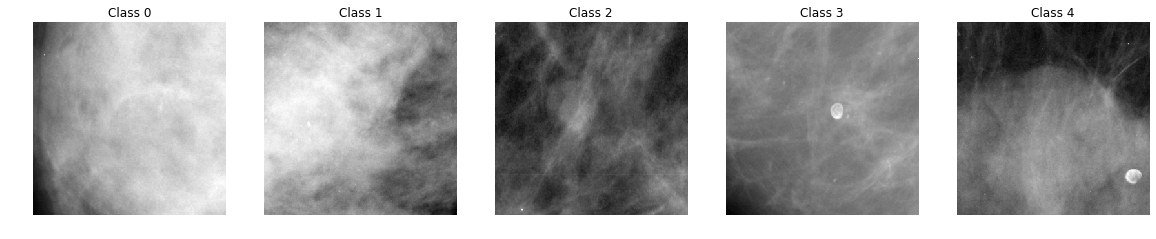

In [11]:
'''PLOT 5 CLASSES OF IMAGES '''

# Subset the dataframe by class
train_label_0_df = train_label_baseline_df[train_label_baseline_df['class']==0]
train_label_1_df = train_label_baseline_df[train_label_baseline_df['class']==1]
train_label_2_df = train_label_baseline_df[train_label_baseline_df['class']==2]
train_label_3_df = train_label_baseline_df[train_label_baseline_df['class']==3]
train_label_4_df = train_label_baseline_df[train_label_baseline_df['class']==4]

#Get random ids
id_0 = np.random.choice(train_label_0_df['id'])
id_1 = np.random.choice(train_label_1_df['id'])
id_2 = np.random.choice(train_label_2_df['id'])
id_3 = np.random.choice(train_label_3_df['id'])
id_4 = np.random.choice(train_label_4_df['id'])

#Plot images
fig = plt.figure(figsize=(20,20))
ax0 = fig.add_subplot(1,5,1)
load_image(id_0,True);
ax0.set_title('Class 0')
ax1 = fig.add_subplot(1,5,2)
load_image(id_1,True);
ax1.set_title('Class 1')
ax2 = fig.add_subplot(1,5,3)
load_image(id_2,True);
ax2.set_title('Class 2')
ax3 = fig.add_subplot(1,5,4)
load_image(id_3,True);
ax3.set_title('Class 3')
ax4 = fig.add_subplot(1,5,5)
load_image(id_4,True);
ax4.set_title('Class 4');

The images above are the ROI of original scans. Without medical knowledge, it seems difficult to distinguish the different classes based on the above images. However, these are random images selected from the dataset. We also plotted the mean image for each class, illustrated below, to get a sense of whether the spatial distribution of light differs systematically by class:

In [ ]:
'''PLOT MEAN IMAGE OF EACH CLASS'''
fig = plt.figure(figsize=(20,20))
axs = []
im_mean = []
for i in range(5):
    axs.append(fig.add_subplot(1,5,i+1))
    im_mean.append(np.zeros((299,299)))
    df_temp = train_label_df[train_label_df['class']==i]
    n_image_temp = df_temp.shape[0]
    for j in range(n_image_temp):
        im_temp = load_image(df_temp['id'].values[j])
        im_mean[i]+=im_temp[:,:,0]
    im_mean[i] = im_mean[i]/n_image_temp
    axs[i].imshow(im_mean[i],cmap='gray')
    axs[i].axis('off')
    axs[i].set_title('Mean image class '+str(i))

We see that calcifications (corresponding to classes 1 and 3) are generally more "diffuse" than masses (classes 2 and 4), though that there is not a clear distinction between benign and malignant growths of either type

### Distribution of image features

We investigate the distribution of the following image features: (1) the average amount of light for each pixel that is not completely black, (2) the standard distribution of the amount of light for each pixel, and (3) the number of pixels that are not completely black.

In [198]:
mean_light_px = []
std_light_px = []
num_blk_px = []
n_images = train_label_baseline_df.shape[0]
for i in range(n_images):
    im_temp = load_image(train_label_baseline_df['id'].values[i])
    mean_light_px.append(np.sum(im_temp[im_temp>0.])/len(im_temp[im_temp>0.]))
    std_light_px.append(np.std(im_temp[im_temp>0.]))
    num_blk_px.append(len(im_temp[im_temp>0.]))
    print(i,'of',n_images)

In [22]:
train_label_baseline_df['mean_light'] = mean_light_px
train_label_baseline_df['std_light'] = std_light_px
train_label_baseline_df['n_light_px'] = num_blk_px
train_label_baseline_df.to_csv('train_df_ref.csv', index = None, header=True)

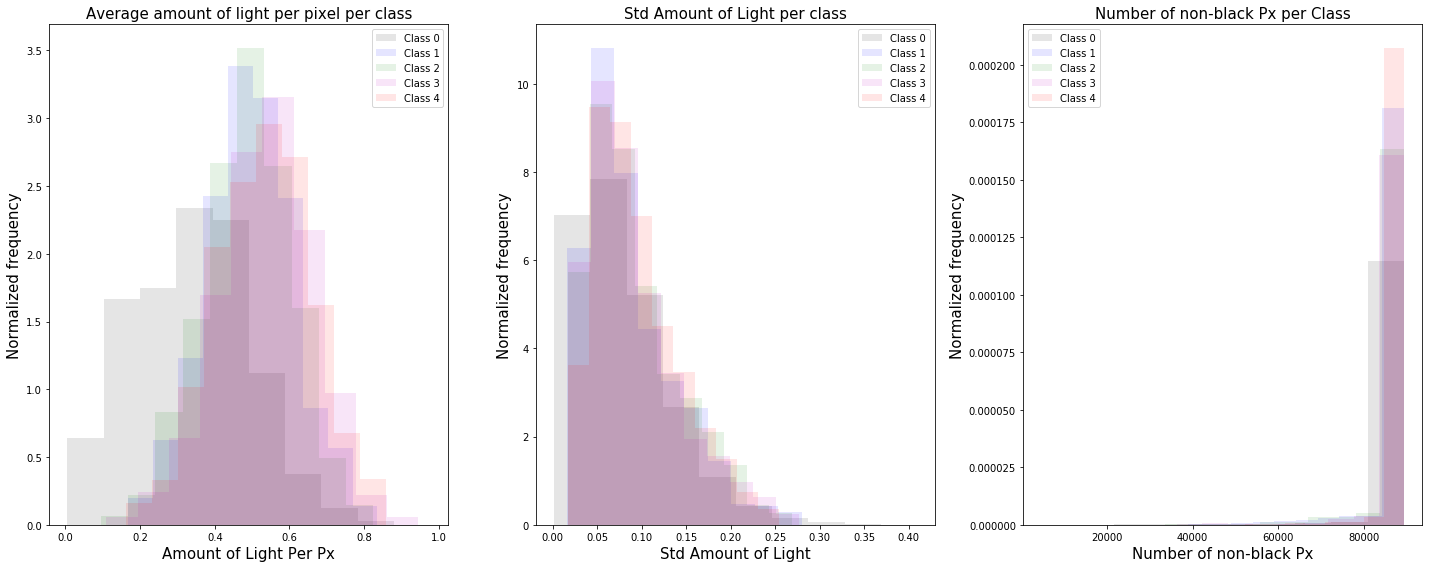

In [28]:
# Subset the dataframe by class
train_label_0_df = train_label_baseline_df[train_label_baseline_df['class']==0]
train_label_1_df = train_label_baseline_df[train_label_baseline_df['class']==1]
train_label_2_df = train_label_baseline_df[train_label_baseline_df['class']==2]
train_label_3_df = train_label_baseline_df[train_label_baseline_df['class']==3]
train_label_4_df = train_label_baseline_df[train_label_baseline_df['class']==4]

#Plot histograms
fig = plt.figure(figsize=(20,8))
axs = []
ylabels = ['Amount of Light Per Px','Std Amount of Light','Number of non-black Px']
titles  = ['Average amount of light per pixel per class','Std Amount of Light per class','Number of non-black Px per Class']
values  = ['mean_light','std_light','n_light_px']
for i in range(3):
    axs.append(fig.add_subplot(1,3,i+1))
    axs[i].hist(train_label_0_df[values[i]].values,color='k',alpha=0.1,label='Class 0',density=True)
    axs[i].hist(train_label_1_df[values[i]].values,color='b',alpha=0.1,label='Class 1',density=True)
    axs[i].hist(train_label_2_df[values[i]].values,color='g',alpha=0.1,label='Class 2',density=True)
    axs[i].hist(train_label_3_df[values[i]].values,color='m',alpha=0.1,label='Class 3',density=True)
    axs[i].hist(train_label_4_df[values[i]].values,color='r',alpha=0.1,label='Class 4',density=True)
    axs[i].set_xlabel(ylabels[i],fontsize=15)
    axs[i].set_ylabel('Normalized frequency',fontsize=15)
    axs[i].set_title(titles[i],fontsize=15)
    axs[i].legend();
plt.tight_layout()

From the distributions above, we see that for higher class labels, the mean of the distribution is shifted to the right and the images contain more light. The left tail of the distribution for class $0$ is a clear indication that we have un-cleaned images with text labels or black backgrounds as shown below.

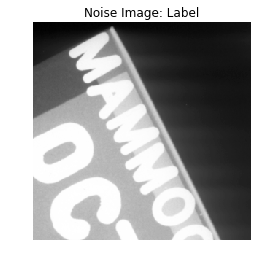

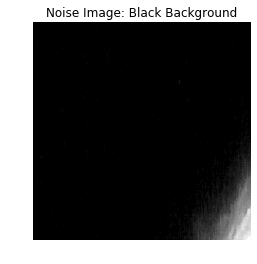

In [143]:
id_label = 'c19962'
id_blk  =  'c3892'
load_image(id_label,True);
plt.title('Noise Image: Label')
plt.show()
load_image(id_blk,True);
plt.title('Noise Image: Black Background')
plt.show()

To try to remove the noisy images, let us plot the scatter plot for the normal class.

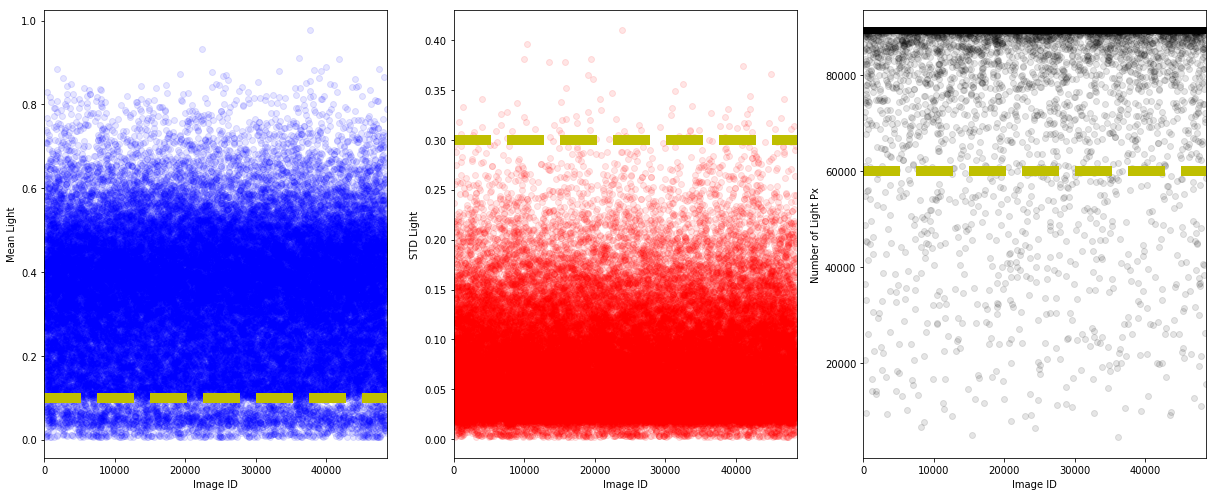

In [171]:
n_im_normal = train_label_0_df.shape[0]
thres_mean = 0.1
thres_std  = 0.3
thres_n    = 60000
fig = plt.figure(figsize=(17,7))
ax0 = fig.add_subplot(131)
ax0.plot(train_label_0_df['mean_light'].values,'ob',alpha=0.1)
ax0.plot([0,50000],[thres_mean,thres_mean],'--y',linewidth=10)
ax0.set_xlabel('Image ID')
ax0.set_ylabel('Mean Light')
ax0.set_xlim(0,n_im_normal)
ax1 = fig.add_subplot(132)
ax1.plot(train_label_0_df['std_light'].values,'or',alpha=0.1)
ax1.plot([0,50000],[thres_std,thres_std],'--y',linewidth=10)
ax1.set_xlim(0,n_im_normal)
ax1.set_xlabel('Image ID')
ax1.set_ylabel('STD Light')
ax2 = fig.add_subplot(133)
ax2.plot(train_label_0_df['n_light_px'].values,'ok',alpha=0.1)
ax2.plot([0,50000],[thres_n,thres_n],'--y',linewidth=10)
ax2.set_xlim(0,n_im_normal)
ax2.set_xlabel('Image ID')
ax2.set_ylabel('Number of Light Px')
plt.set_fontsize=20
plt.tight_layout()

Visually, from the above plots, we put a lower bound on the mean and number of non-black pixels as well as a upper bound on the standard deviation. Let us investigate the rejected images.

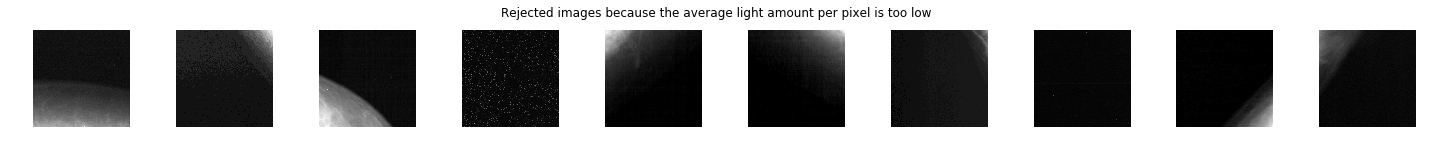

In [172]:
'''TOO DARK'''
too_dark_df = train_label_0_df[train_label_0_df['mean_light'].values<thres_mean]
n_too_dark = too_dark_df.shape[0]
n_sequence = 10
fig = plt.figure(figsize=(20,10))
axs = []
for i in range(n_sequence):
    axs.append(fig.add_subplot(1,10,i+1))
    id_rand = random.randint(0,n_too_dark)
    load_image(too_dark_df['id'].values[id_rand],True);
plt.suptitle('Rejected images because the average light amount per pixel is too low',y=0.6);
plt.tight_layout()

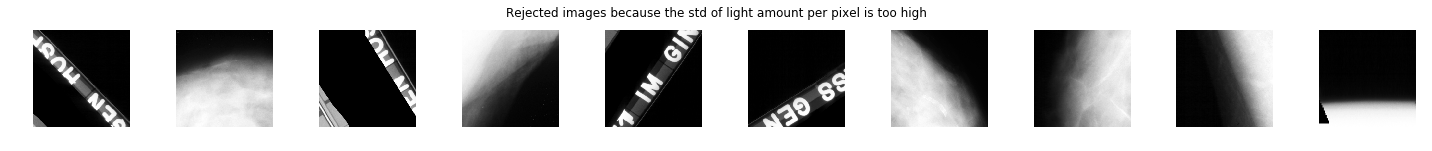

In [173]:
'''TOO HIGH STD'''
too_high_std_df = train_label_0_df[train_label_0_df['std_light'].values>thres_std]
n_too_high_std_df = too_high_std_df.shape[0]
n_sequence = 10
fig = plt.figure(figsize=(20,10))
axs = []
for i in range(n_sequence):
    axs.append(fig.add_subplot(1,10,i+1))
    id_rand = random.randint(0,n_too_high_std_df)
    load_image(too_high_std_df['id'].values[id_rand],True);
plt.suptitle('Rejected images because the std of light amount per pixel is too high',y=0.6);
plt.tight_layout()

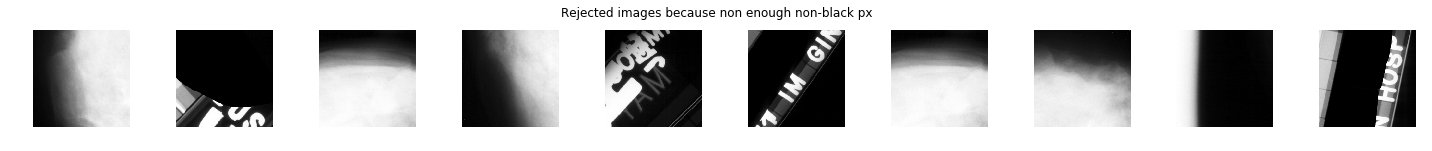

In [174]:
'''TOO LOW NUMBER OF NON-BLACK PIXELS'''
too_low_blk_px_df = train_label_0_df[train_label_0_df['std_light'].values>thres_std]
n_too_low_blk_px_df = too_low_blk_px_df.shape[0]
n_sequence = 10
fig = plt.figure(figsize=(20,10))
axs = []
for i in range(n_sequence):
    axs.append(fig.add_subplot(1,10,i+1))
    id_rand = random.randint(0,n_too_low_blk_px_df)
    load_image(too_low_blk_px_df['id'].values[id_rand],True);
plt.suptitle('Rejected images because non enough non-black px',y=0.6);
plt.tight_layout()

As we can see from the results above, the threshold on the mean value is good at capturing the black background without compromising the normal breast tissue images. However, the most challenging images to detect and remove are the labels. The threshold on the standard deviation and the number of non-black pixels are good at capturing the labels, but are also removing some images that looks normal.

## Model Pre-Processing
Before training our models for classification, we will pre-process the training and test data. We will look at the following models:

- Model 0: Raw pre-processed DDSM dataset (baseline)
- Model 1: Cleaned normal class
- Model 2: Classification of abnormalities (Classes 1 to 4)
- Model 3: Normal vs abnormal (Class 0 vs 1-4)
- Model 4: Benign vs malignant calcification
- Model 5: Benign vs malignant mass

### Model 0: Raw Pre-Processed DDSM Dataset (Baseline)

The baseline model classifies the images from the pre-processed DDSM dataset into the following $5$ classes:

- $0$: Normal
- $1$: Benign Calcification
- $2$: Benign Mass
- $3$: Malignant Calcification
- $4$: Malignant Mass

Given the fact that the test data do not include calcification, we combine and reshuffle the test and cross-validation data into a single test dataset. The cross-validation data for training will be taken directly from the training dataset.

For the baseline model, we directly use the pre-processed data.

In [216]:
train_label_baseline_df = pd.read_csv('train_df_ref.csv')

In [227]:
# Format train data
train_df_model_0 = train_label_baseline_df
train_df_model_0.loc[:,'y'] = train_df_model_0.loc[:,'y'].astype('str')
train_df_model_0.to_csv('train_df_model_0.csv', index = None, header=True)

# Format test data
test_df_model_0 = test_df_ref
test_df_model_0.to_csv('test_df_model_0.csv', index = None, header=True)

### Model  1: Cleaned Normal Class

For the model $1$ we remove from the normal class the noisy images based on the threshold values

In [228]:
# Format train data
indexdrop = train_label_baseline_df[ (train_label_baseline_df['class'] == 0) & ((train_label_baseline_df['mean_light'] <= thres_mean) \
                                   | (train_label_baseline_df['std_light'] >= thres_std)\
                                   | (train_label_baseline_df['n_light_px'] <= thres_n))].index
n_drop = len(indexdrop)
print(str(n_drop)+' images were dropped')
train_df_model_1 = train_label_baseline_df.drop(indexdrop)
train_df_model_1.to_csv('train_df_model_1.csv', index = None, header=True)

# Format test data
test_df_model_1 = test_df_ref
test_df_model_1.to_csv('test_df_model_1.csv', index = None, header=True)

3058 images were dropped


### Model 2: Classification of Abnormalities (Classes 1 to 4)

In [229]:
# Format train data
train_df_model_2 = train_label_baseline_df[(train_label_baseline_df['class'].values!=0)]
train_df_model_2.loc[:,'y'] = train_df_model_2.loc[:,'y'].astype('int64')-1
train_df_model_2.loc[:,'y'] = train_df_model_2.loc[:,'y'].astype('str')
train_df_model_2 =train_df_model_2.reset_index(drop=True)
train_df_model_2.to_csv('train_df_model_2.csv', index = None, header=True)

# Format test data
test_df_model_2 = test_df_ref[(test_df_ref['class'].values!=0)]
test_df_model_2.loc[:,'y'] = test_df_model_2.loc[:,'y'].astype('int64')-1
test_df_model_2.loc[:,'y'] = test_df_model_2.loc[:,'y'].astype('str')
test_df_model_2 =test_df_model_2.reset_index(drop=True)
test_df_model_2.head()
test_df_model_2.to_csv('test_df_model_2.csv', index = None, header=True)
test_df_model_2.head()

,index,id,class,filename,y
0,4,img5,1,img5.png,0
1,20,img21,2,img21.png,1
2,27,img28,4,img28.png,3
3,31,img32,3,img32.png,2
4,48,img49,2,img49.png,1


### Model 3: Normal vs Abnormal (Class 0 vs 1-4)

In [230]:
train_df_model_3 = train_df_model_1
train_df_model_3.loc[:,'y'] = train_df_model_3.loc[:,'y'].replace('2','1')
train_df_model_3.loc[:,'y'] = train_df_model_3.loc[:,'y'].replace('3','1')
train_df_model_3.loc[:,'y'] = train_df_model_3.loc[:,'y'].replace('4','1')
train_df_model_3 =train_df_model_3.reset_index(drop=True)
train_df_model_3.to_csv('train_df_model_3.csv', index = None, header=True)

# Format test data
test_df_model_3 = test_df_ref
test_df_model_3.loc[:,'y'] = test_df_model_3.loc[:,'y'].replace('2','1')
test_df_model_3.loc[:,'y'] = test_df_model_3.loc[:,'y'].replace('3','1')
test_df_model_3.loc[:,'y'] = test_df_model_3.loc[:,'y'].replace('4','1')
test_df_model_3 =test_df_model_3.reset_index(drop=True)
test_df_model_3.to_csv('test_df_model_3.csv', index = None, header=True)
test_df_model_3.head()

,index,id,class,filename,y
0,0,img1,0,img1.png,0
1,1,img2,0,img2.png,0
2,2,img3,0,img3.png,0
3,3,img4,0,img4.png,0
4,4,img5,1,img5.png,1


### Model 4: Benign vs Malignant Calcification

In [231]:
# Format train data
train_df_model_4 = \
train_label_baseline_df[(train_label_baseline_df['class'].values==1) | (train_label_baseline_df['class'].values==3)]
train_df_model_4.loc[:,'y'] = train_df_model_4.loc[:,'y'].replace('1','0')
train_df_model_4.loc[:,'y'] = train_df_model_4.loc[:,'y'].replace('3','1')
train_df_model_4 =train_df_model_4.reset_index(drop=True)
train_df_model_4.to_csv('train_df_model_4.csv', index = None, header=True)

# Format test data
test_df_model_4 = \
test_df_ref[(test_df_ref['class'].values==1) | (test_df_ref['class'].values==3)]
test_df_model_4.loc[:,'y'] = test_df_model_4.loc[:,'y'].replace('1','0')
test_df_model_4.loc[:,'y'] = test_df_model_4.loc[:,'y'].replace('3','1')
test_df_model_4 =test_df_model_4.reset_index(drop=True)
test_df_model_4.to_csv('test_df_model_4.csv', index = None, header=True)
test_df_model_4.head()

,index,id,class,filename,y
0,4,img5,1,img5.png,0
1,31,img32,3,img32.png,0
2,50,img51,3,img51.png,0
3,54,img55,1,img55.png,0
4,60,img61,3,img61.png,0


### Model 5: Benign vs Malignant Mass

In [232]:
# Format train data
train_df_model_5 = \
train_label_baseline_df[(train_label_baseline_df['class'].values==2) | (train_label_baseline_df['class'].values==4)]
train_df_model_5.loc[:,'y'] = train_df_model_5.loc[:,'y'].replace('2','0')
train_df_model_5.loc[:,'y'] = train_df_model_5.loc[:,'y'].replace('4','1')
train_df_model_5 =train_df_model_5.reset_index(drop=True)
train_df_model_5.to_csv('train_df_model_5.csv', index = None, header=True)

# Format test data
test_df_model_5 = \
test_df_ref[(test_df_ref['class'].values==2) | (test_df_ref['class'].values==4)]
test_df_model_5.loc[:,'y'] = test_df_model_5.loc[:,'y'].replace('2','0')
test_df_model_5.loc[:,'y'] = test_df_model_5.loc[:,'y'].replace('4','1')
test_df_model_5 =test_df_model_5.reset_index(drop=True)
test_df_model_5.to_csv('test_df_model_5.csv', index = None, header=True)
test_df_model_5.head()

,index,id,class,filename,y
0,20,img21,2,img21.png,1
1,27,img28,4,img28.png,1
2,48,img49,2,img49.png,1
3,75,img76,2,img76.png,1
4,86,img87,2,img87.png,1
